In [1]:
import pandas as pd
from sklearn import preprocessing 

In [2]:
df = pd.read_csv('./data/segmented_customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19.0,15.0,39.0
1,2,Male,21.0,15.0,81.0
2,3,Female,20.0,16.0,6.0
3,4,Female,23.0,16.0,77.0
4,5,Female,31.0,17.0,40.0


In [6]:
# посмотрим, есть ли пропуски в датасете
df.isna().sum()

CustomerID                0
Gender                    0
Age                       2
Annual Income (k$)        2
Spending Score (1-100)    1
dtype: int64

In [7]:
# и как они выглядят
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
200,201,Female,21.0,NaN,40.0
201,202,Female,30.0,127.0,NaN
202,203,Male,80.0,NaN,20.0
203,204,Male,NaN,16.0,120.0
204,205,Female,NaN,9.0,80.0


In [8]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(
    columns = {
        'CustomerID' : 'customer_id', 'Gender' : 'gender', 
        'Age': 'age', 'Annual Income (k$)': 'annual_income', 
        'Spending Score (1-100)': 'spending_score'
        }, 
    inplace = True
)

In [11]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


In [12]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

In [13]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [14]:
X = df[['age', 'annual_income', 'spending_score']]

In [15]:
# Импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

In [22]:
clustering = DBSCAN()

In [23]:
clusters_dbscan = clustering.fit_predict(X)
df['dbscan_res_def'] = clusters_dbscan

In [24]:
get_3d_visualization(df, 'dbscan_res_def')

In [25]:
#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

In [33]:

dbscan = DBSCAN(eps=7)
clustering_dbscan_res = dbscan.fit_predict(X)
get_3d_visualization(df, clustering_dbscan_res)

In [34]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

In [36]:
aggl_pred = get_aggl_clustering(X, n_clusters=6)
df['aggl_clusterization'] = aggl_pred

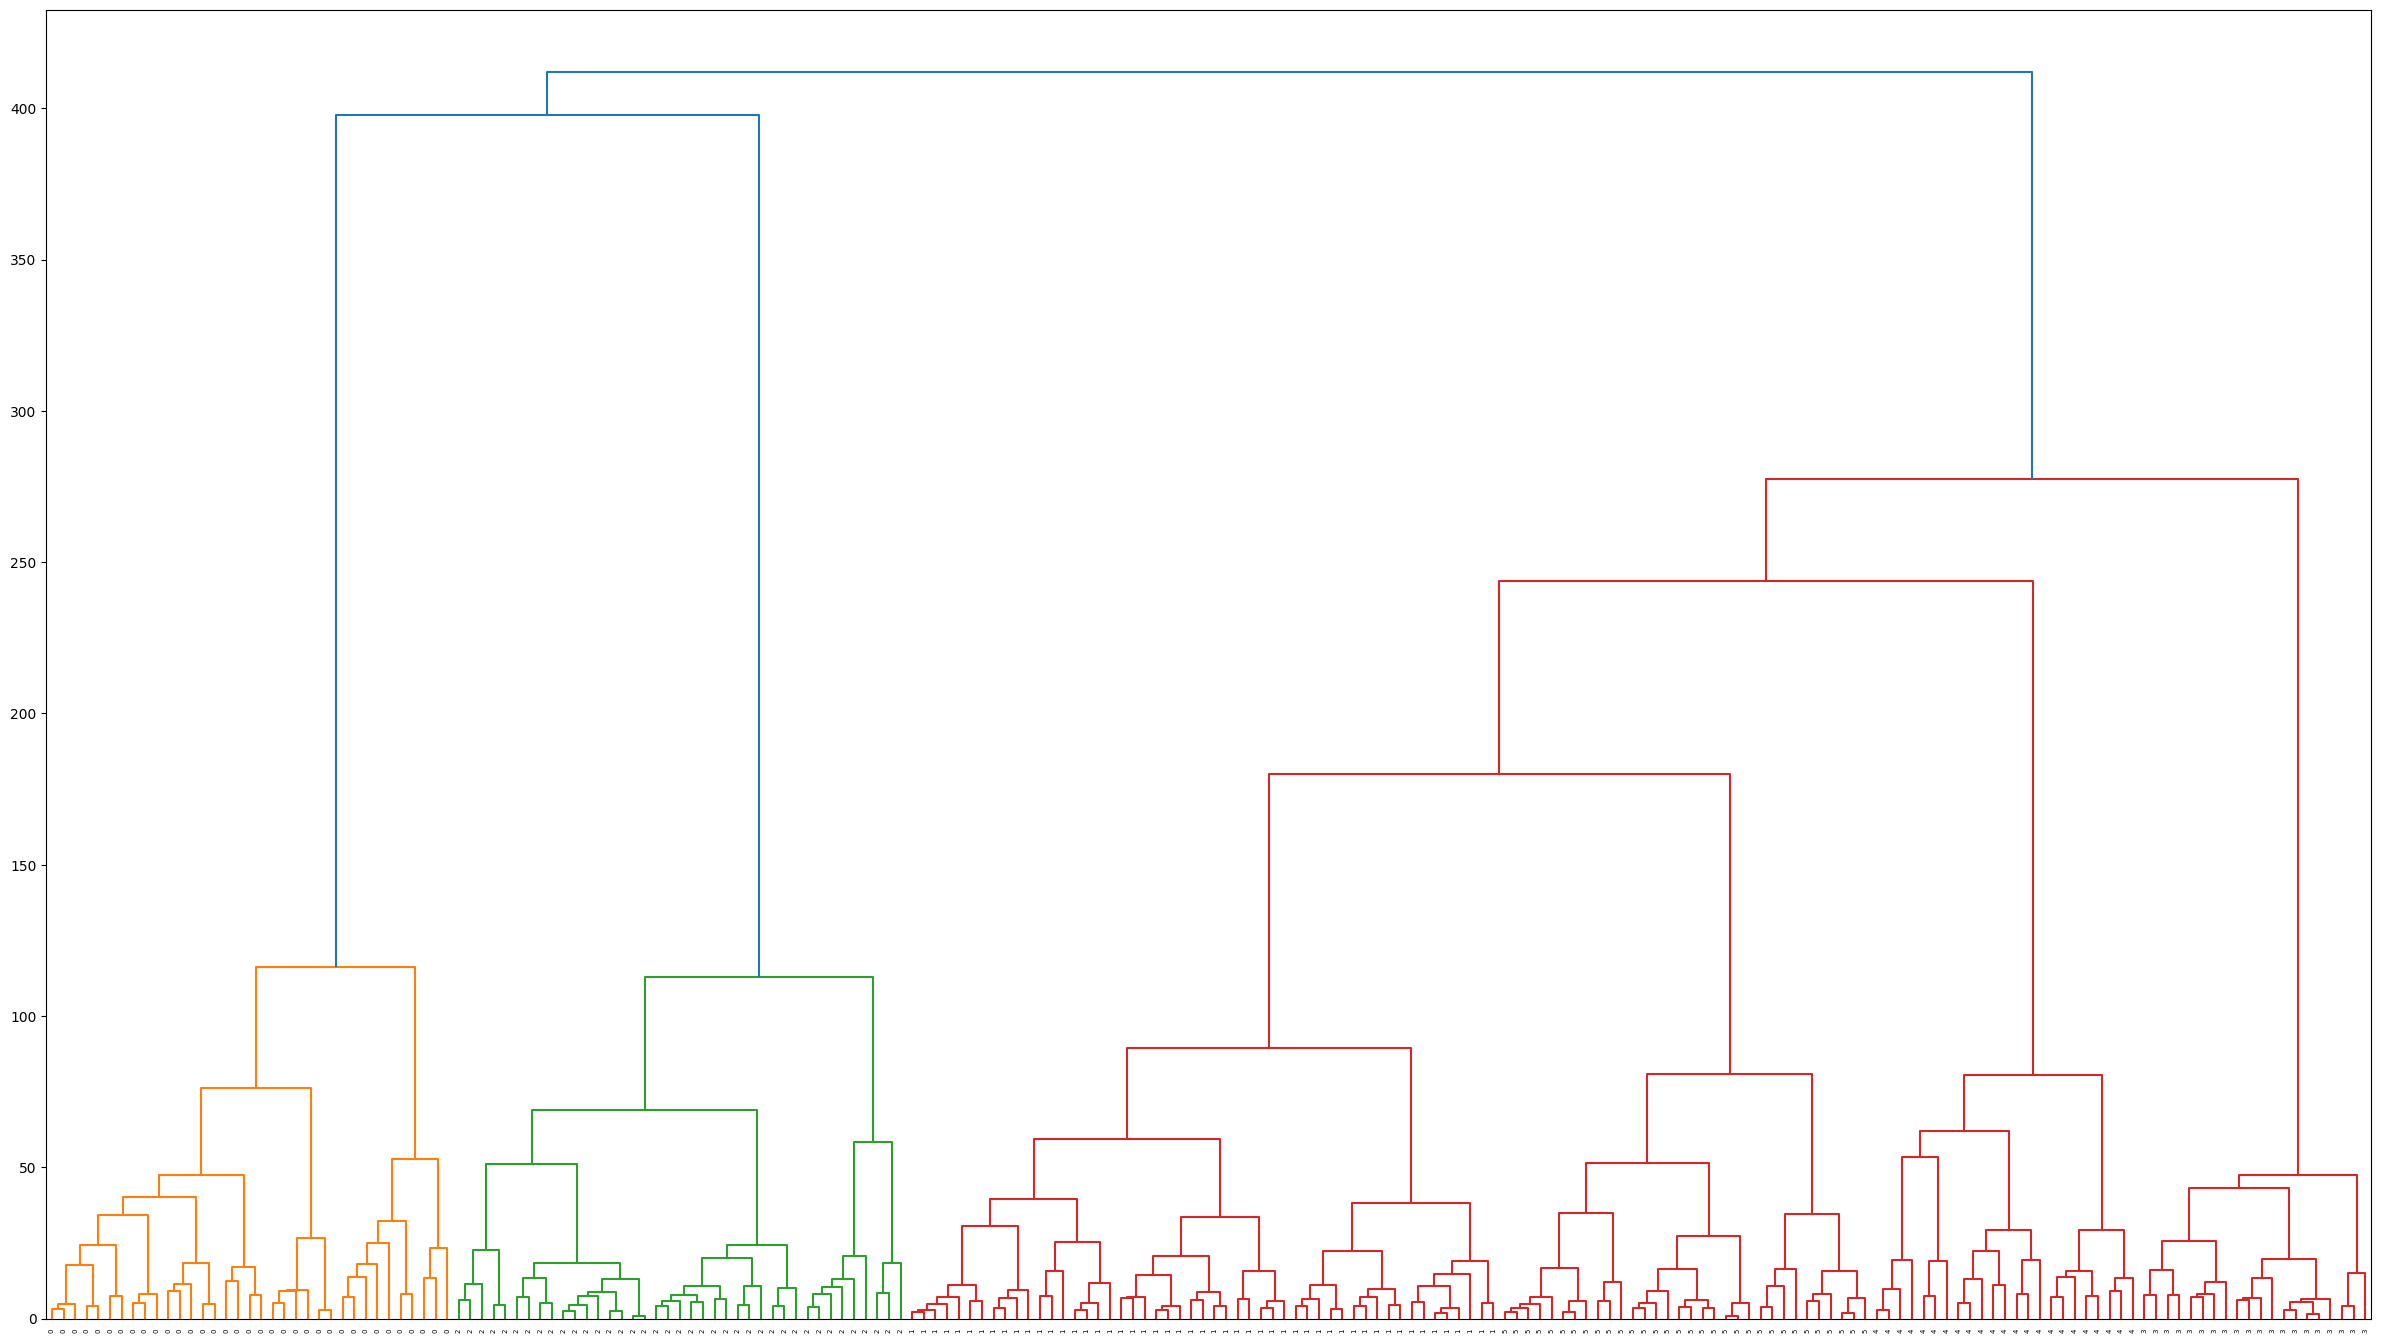

In [40]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# рассчитаем расстояния между кластерами
linked = linkage(X, 'ward')

plt.figure(figsize=(30, 17))

# визуализируем дендрограмму с ориентацией top
# сначала будут отрисовываться кластеры с минимальным расстоянием между ними
dendrogram(Z=linked,
            orientation='top',
            labels=df['aggl_clusterization'].to_list(),
            distance_sort='descending',
            show_leaf_counts=True
)

plt.show()

In [41]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns


In [43]:
def get_silhouette(cluster_num, X):
    k_means = KMeans(n_clusters=cluster_num, init='k-means++',
                    n_init=10, random_state=42)
    k_means.fit(X)
    silhouette = silhouette_score(X, k_means.predict(X))
    return silhouette


<AxesSubplot: xlabel='clusters', ylabel='silhouette'>

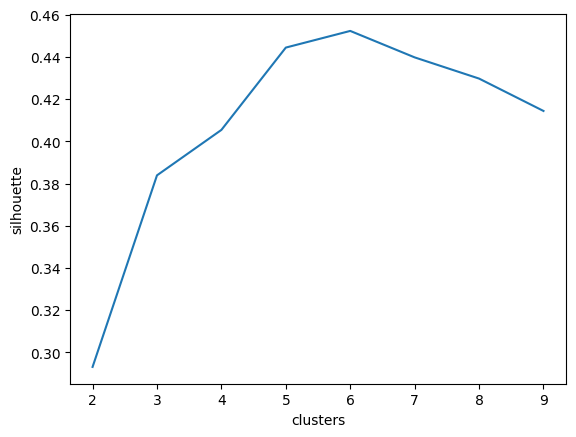

In [48]:
sil_scores = {'silhouette':[], 'clusters':[]}

for i in range(2,10):
    sil_scores['silhouette'].append(get_silhouette(i, X))
    sil_scores['clusters'].append(i)
sil_scores = pd.DataFrame(sil_scores)

sns.lineplot(
    data= sil_scores, 
    x='clusters',
    y='silhouette'
)